In [2]:
!pip install numpy pandas matplotlib seaborn
!pip install scikit-learn
!pip install nltk
!pip install wordcloud
!pip install xgboost
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
    --------------------------------------- 1.0/56.8 MB 7.2 MB/s eta 0:00:08
   -- ------------------------------------- 3.1/56.8 MB 9.2 MB/s eta 0:00:06
   --- ------------------------------------ 5.5/56.8 MB 9.9 MB/s eta 0:00:06
   ----- ---------------------------------- 8.1/56.8 MB 10.7 MB/s eta 0:00:05
   ------- -------------------------------- 10.5/56.8 MB 10.7 MB/s eta 0:00:05
   --------- ------------------------------ 13.1/56.8 MB 11.1 MB/s eta 0:00:04
   ----------- ---------------------------- 15.7/56.8 MB 11.2 MB/s eta 0:

  You can safely remove it manually.
  You can safely remove it manually.


In [4]:
# ===============================
# 1. Import Libraries
# ===============================
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from gensim.models import Word2Vec

In [5]:
# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JANHAVI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JANHAVI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# ===============================
# 2. Load Data
# ===============================
data_files = ['Youtube01-Psy.csv','Youtube02-KatyPerry.csv',
              'Youtube03-LMFAO.csv','Youtube04-Eminem.csv','Youtube05-Shakira.csv']

train_data = []
for file in data_files:
    data = pd.read_csv(file)
    train_data.append(data)
train_data = pd.concat(train_data)

print("Data shape:", train_data.shape)
print(train_data.head())

Data shape: (1956, 5)
                                    COMMENT_ID            AUTHOR  \
0  LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU         Julius NM   
1  LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A       adam riyati   
2  LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8  Evgeny Murashkin   
3          z13jhp0bxqncu512g22wvzkasxmvvzjaz04   ElNino Melendez   
4          z13fwbwp1oujthgqj04chlngpvzmtt3r3dw            GsMega   

                  DATE                                            CONTENT  \
0  2013-11-07T06:20:48  Huh, anyway check out this you[tube] channel: ...   
1  2013-11-07T12:37:15  Hey guys check out my new channel and our firs...   
2  2013-11-08T17:34:21             just for test I have to say murdev.com   
3  2013-11-09T08:28:43   me shaking my sexy ass on my channel enjoy ^_^ ﻿   
4  2013-11-10T16:05:38            watch?v=vtaRGgvGtWQ   Check this out .﻿   

   CLASS  
0      1  
1      1  
2      1  
3      1  
4      1  


In [7]:
# ===============================
# 3. Preprocessing
# ===============================
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = re.findall("[A-Za-z]+", str(text).lower())
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

train_data["processed_content"] = train_data["CONTENT"].apply(preprocess_text)

# Drop unnecessary columns
train_data = train_data[["processed_content","CLASS"]]

print(train_data.head())

                                   processed_content  CLASS
0             huh anyway check tube channel kobyoshi      1
1  hey guy check new channel first vid u monkey m...      1
2                                test say murdev com      1
3                      shaking sexy as channel enjoy      1
4                          watch v vtarggvgtwq check      1


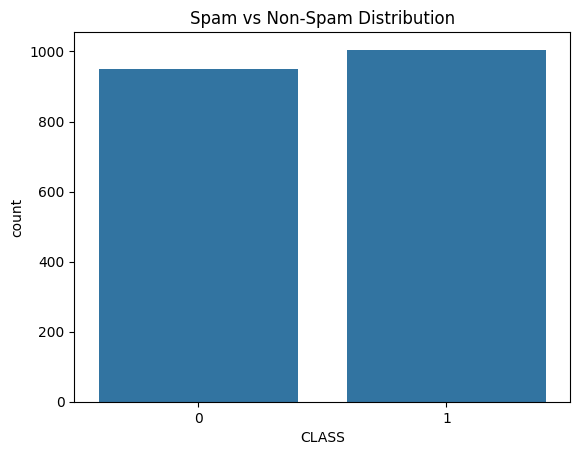

In [8]:
# ===============================
# 4. EDA & Visualizations
# ===============================
# Class distribution
sns.countplot(x="CLASS", data=train_data)
plt.title("Spam vs Non-Spam Distribution")
plt.show()

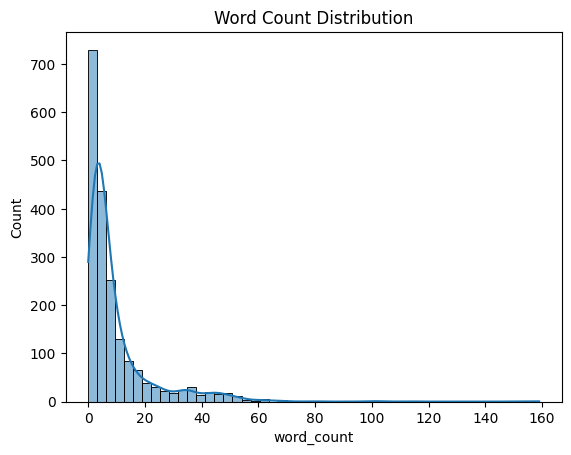

In [9]:
# Word count distribution
train_data["word_count"] = train_data["processed_content"].apply(lambda x: len(x.split()))
sns.histplot(train_data["word_count"], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.show()

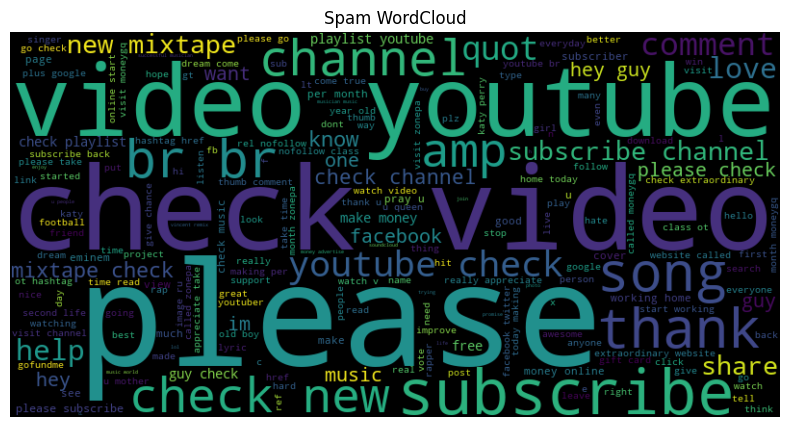

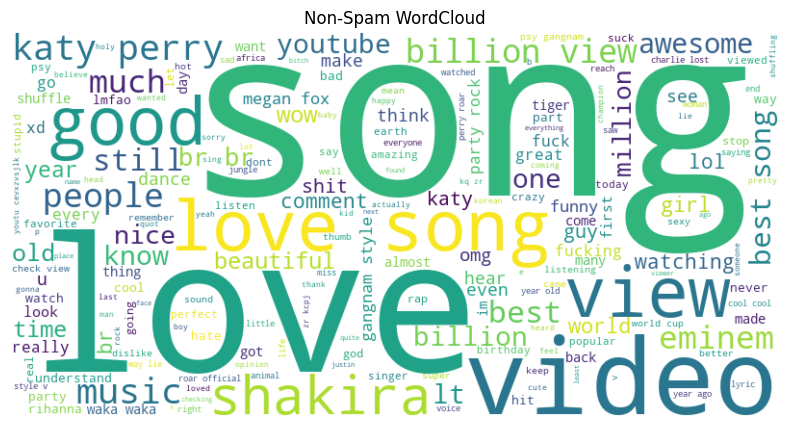

In [10]:
# WordClouds
spam_words = " ".join(train_data[train_data["CLASS"]==1]["processed_content"])
ham_words = " ".join(train_data[train_data["CLASS"]==0]["processed_content"])

plt.figure(figsize=(10,5))
wc = WordCloud(width=800, height=400, background_color="black").generate(spam_words)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Spam WordCloud")
plt.show()

plt.figure(figsize=(10,5))
wc = WordCloud(width=800, height=400, background_color="white").generate(ham_words)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Non-Spam WordCloud")
plt.show()


In [11]:
# ===============================
# 5. Train-Test Split
# ===============================
x_train, x_test, y_train, y_test = train_test_split(
    train_data["processed_content"], train_data["CLASS"], 
    test_size=0.2, random_state=42
)

In [12]:
# ===============================
# 6. TF-IDF Vectorization
# ===============================
count_vect = CountVectorizer(stop_words="english")
x_train_counts = count_vect.fit_transform(x_train)
x_test_counts = count_vect.transform(x_test)

transformer = TfidfTransformer()
x_train_tfidf = transformer.fit_transform(x_train_counts)
x_test_tfidf = transformer.transform(x_test_counts)

print("TF-IDF Shape:", x_train_tfidf.shape)

TF-IDF Shape: (1564, 3145)


In [13]:
# ===============================
# 7. Word2Vec Embeddings
# ===============================
sentences = [text.split() for text in train_data["processed_content"]]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_w2v_vector(text):
    words = text.split()
    vecs = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
    return np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(100)

X_w2v = np.array([get_w2v_vector(doc) for doc in train_data["processed_content"]])

x_train_w2v, x_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, train_data["CLASS"], test_size=0.2, random_state=42
)


In [14]:
# ===============================
# 8. Model Training & Evaluation
# ===============================
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(),
    "NaiveBayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "XGBoost": XGBClassifier(eval_metric="logloss")
}

results = {}

for name, clf in models.items():
    print(f"\n===== {name} with TF-IDF =====")
    clf.fit(x_train_tfidf, y_train)
    preds = clf.predict(x_test_tfidf)
    acc = accuracy_score(y_test, preds)
    print(classification_report(y_test, preds))
    results[name] = acc

# Try Logistic Regression with Word2Vec embeddings
print("\n===== LogisticRegression with Word2Vec =====")
lr_w2v = LogisticRegression(max_iter=500)
lr_w2v.fit(x_train_w2v, y_train_w2v)
preds_w2v = lr_w2v.predict(x_test_w2v)
acc_w2v = accuracy_score(y_test_w2v, preds_w2v)
print(classification_report(y_test_w2v, preds_w2v))
results["LogReg_Word2Vec"] = acc_w2v



===== LogisticRegression with TF-IDF =====
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       176
           1       0.96      0.94      0.95       216

    accuracy                           0.95       392
   macro avg       0.95      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392


===== RandomForest with TF-IDF =====
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       176
           1       0.98      0.94      0.96       216

    accuracy                           0.95       392
   macro avg       0.95      0.96      0.95       392
weighted avg       0.96      0.95      0.95       392


===== NaiveBayes with TF-IDF =====
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       176
           1       0.90      0.95      0.92       216

    accuracy                           0.91       392
   macro a


Model Comparison:
                 Model  Accuracy
0  LogisticRegression  0.946429
1        RandomForest  0.954082
2          NaiveBayes  0.913265
3                 SVM  0.948980
4             XGBoost  0.954082
5     LogReg_Word2Vec  0.650510


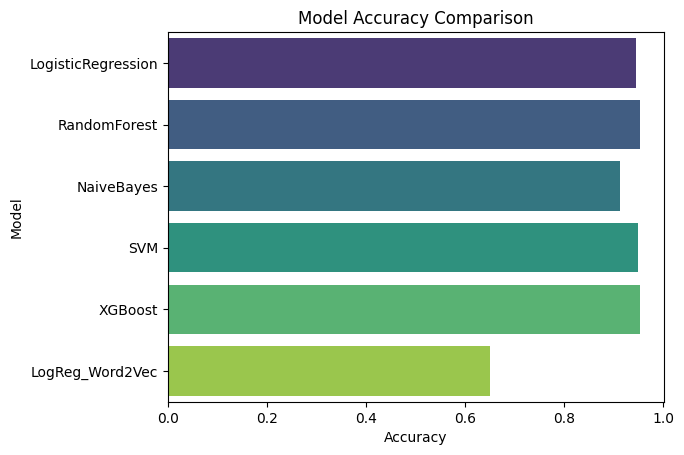

In [16]:
# ===============================
# 9. Compare Results
# ===============================
results_df = pd.DataFrame(list(results.items()), columns=["Model","Accuracy"])
print("\nModel Comparison:\n", results_df)

#sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
sns.barplot(x="Accuracy", y="Model", data=results_df, hue="Model", dodge=False, palette="viridis", legend=False)

plt.title("Model Accuracy Comparison")
plt.show()
